### Setup

In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn import inspection
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier

from why import data
from why.interpret import PermutationImportance, ImpurityImportance
from why.explainer import Explainer

### Cervical Cancer

In [ ]:
train, test, target = data.load_cervical_cancer()

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
X_train, y_train = train.drop(columns=target), train[target]
X_test, y_test = test.drop(columns=target), test[target]

In [ ]:
y_train.value_counts(normalize=True)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=3).fit(X_train, y_train)
gbm = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=3).fit(X_train, y_train)

In [ ]:
model = gbm

In [ ]:
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

In [ ]:
metrics.roc_auc_score(y_train, train_preds)

In [ ]:
metrics.roc_auc_score(y_test, test_preds)

In [ ]:
exp = Explainer(train, test, target, model=model, random_feature=False)

In [ ]:
perm_imp = PermutationImportance(exp).calculate_importance(dataset="train", n_jobs=-1, scoring="roc_auc")
fig = perm_imp.plot()
plt.plot()

### Rain in Australia

In [2]:
COLS = [
    "Year",
    "Month",
    # "DayOfMonth",
    "Location",
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustDir",
    "WindGustSpeed",
    "WindDir9am",
    "WindDir3pm",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm",
    "RainToday",
    "RainTomorrow",
]

In [3]:
df = (
    pd.read_csv("../data/raw/weatherAUS.csv", parse_dates=["Date"])
    .query("Date >= '2014-01-01' and Date <= '2015-12-31'")
    .dropna(subset=["RainTomorrow"])
    .assign(Year=lambda df: df["Date"].dt.year,
            Month=lambda df: df["Date"].dt.month)
            # DayOfMonth=lambda df: df["Date"].dt.day)
    [COLS]
)
train = df.loc[df["Year"] < 2015]
test = df.loc[df["Year"] >= 2015]
X_train, y_train = train.drop(columns="RainTomorrow"), train["RainTomorrow"]
X_test, y_test = test.drop(columns="RainTomorrow"), test["RainTomorrow"]

In [4]:
CAT_COLS = ["Year", "Month", "Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]
NUM_COLS = list(set(X_train.columns) - set(CAT_COLS))

In [5]:
cat_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent", add_indicator=False)),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="mean"))])
transformer = ColumnTransformer([("cat", cat_pipe, CAT_COLS), ("num", num_pipe, NUM_COLS)], sparse_threshold=0).fit(X_train)

In [6]:
onehot_feature_names = transformer.named_transformers_["cat"].named_steps["onehot"].get_feature_names(input_features=CAT_COLS)
feature_names = np.r_[onehot_feature_names, NUM_COLS]

In [7]:
train = (
    pd.DataFrame(transformer.transform(X_train), columns=feature_names)
    .astype({feat: int for feat in onehot_feature_names})
    .assign(RainTomorrow=y_train.values)
)
test = (
    pd.DataFrame(transformer.transform(X_test), columns=feature_names)
    .astype({feat: int for feat in onehot_feature_names})
    .assign(RainTomorrow=y_test.values)
)
target = "RainTomorrow"

In [8]:
X_train, y_train = train.drop(columns=target), train[target]
X_test, y_test = test.drop(columns=target), test[target]

In [9]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, n_jobs=-1).fit(X_train, y_train)
# gbm = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=3, n_jobs=-1).fit(X_train, y_train)

In [10]:
model = rf

In [11]:
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

In [12]:
metrics.roc_auc_score(y_train, train_preds)

0.9915333915209749

In [13]:
metrics.roc_auc_score(y_test, test_preds)

0.8694932728365066

In [15]:
exp = Explainer(train, test, target, model=model, random_feature=False)

[]

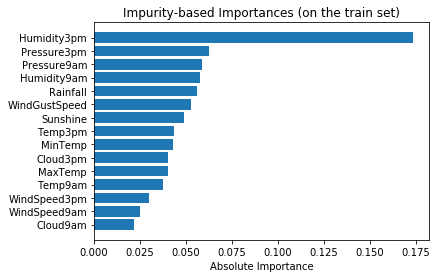

In [22]:
fig = ImpurityImportance(exp).calculate_importance().plot()
plt.plot()

[]

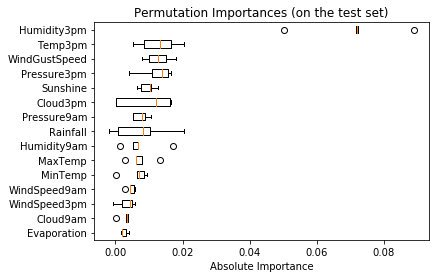

In [18]:
perm_imp = PermutationImportance(exp).calculate_importance(dataset="test", sample_size=500, n_jobs=-1, scoring="roc_auc")
fig = perm_imp.plot()
plt.plot()